<a href="https://www.kaggle.com/code/aisuko/semantic-segmentation-using-lora?scriptVersionId=161875272" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

With LoRA we can reduce the number of trainable parameters in the SegFormer model to only 14% of the original trainable parameters.

LoRA achieves this reduction by adding low-rank **update matrices** to specific blocks of the model, such as the attention blocks. During fine-tuning, only these matrices are trained, while the original model parameters are left unchanged. At inference time, the update matrices are merged with the original model parameters to produce the final classification result. More detail see [About Low Rank Adaptation](https://www.kaggle.com/code/aisuko/fine-tuning-t5-small-with-lora#About-LoRA(Low-Rank-Adaptation)) and [QLora and LoRA](https://www.kaggle.com/code/aisuko/fine-tuning-llama2-with-qlora#Overview)

Semantic segmentation without usign LoRA see here [Semantic segmentation](https://www.kaggle.com/code/aisuko/semantic-segmentation)

In [1]:
!pip install transformers==4.36.2
!pip install accelerate==0.25.0
!pip install evaluate==0.4.1
!pip install datasets==2.15.0
!pip install peft==0.7.1
# !pip install bitsandbytes==0.41.3

  Obtaining dependency information for evaluate==0.4.1 from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
  Obtaining dependency information for datasets==2.15.0 from https://files.pythonhosted.org/packages/e2/cf/db41e572d7ed958e8679018f8190438ef700aeb501b62da9e1eed9e4d69a/datasets-2.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec[http]<=2023.10.0,>=2023.1.0 from https://files.pythonhosted.org/packages/e8/f6/3eccfb530aac90ad1301c582da228e4763f19e719ac8200752a4841b0b2d/fsspec-2023.10.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.1 

In [2]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tune-models-with-LoRA"
os.environ["WANDB_NOTES"] = "Fine tune model with low rank adaptation"
os.environ["WANDB_NAME"] = "ft-mit-b0-with-scene-parse-150-lora"
os.environ["MODEL_NAME"] = "nvidia/mit-b0"

# For debuging on GPU
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # IN kaggle will cause the training stop at the beginning

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
!accelerate estimate-memory ${MODEL_NAME} --library_name transformers

Loading pretrained config for `nvidia/mit-b0` from `transformers`...
config.json: 100%|██████████████████████████| 70.0k/70.0k [00:00<00:00, 350kB/s]
┌────────────────────────────────────────────────────┐
│      Memory Usage for loading `nvidia/mit-b0`      │
├───────┬─────────────┬──────────┬───────────────────┤
│ dtype │Largest Layer│Total Size│Training using Adam│
├───────┼─────────────┼──────────┼───────────────────┤
│float32│   1.41 MB   │ 12.66 MB │      50.65 MB     │
│float16│   720.5 KB  │ 6.33 MB  │      25.32 MB     │
│  int8 │  360.25 KB  │ 3.17 MB  │      12.66 MB     │
│  int4 │  180.12 KB  │ 1.58 MB  │      6.33 MB      │
└───────┴─────────────┴──────────┴───────────────────┘


# Load the dataset

In [4]:
from datasets import load_dataset

ds=load_dataset("scene_parse_150", split="train[:150]")
ds=ds.train_test_split(test_size=0.1)
train_ds=ds["train"]
test_ds=ds["test"]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Prepare label maps

Create a dictionary that maps a label id to a label class, which will be useful when setting up the model later:

* **label2id**: maps the semantic classes of the dataset to integer ids
* **id2label**: maps integer ids back to the semantic classes

In [5]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id="huggingface/label-files"
filename="ade20k-id2label.json"
id2label=json.load(
    open(
        cached_download(
            hf_hub_url(repo_id, filename, repo_type="dataset")),"r"
    )
)

id2label={int(k):v for k,v in id2label.items()}
label2id={v:k for k,v in id2label.items()}

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

Load the SegFormer image processor to prepare the images and annotations for the model. This dataset uses the zero-index as the background class, so make sure to set **do_reduce_labels=True** to subtract one from all labels since the background class is not among the 150 classes.

In [6]:
from transformers import AutoImageProcessor

image_processor=AutoImageProcessor.from_pretrained(os.getenv("MODEL_NAME"), do_reduce_labels=True)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Add a function to apply data augmentation to the images, so that the model is more robust against overfitting. Here we use the ColorJitter function from torchvision to randomly change the color properties of an image.

In [7]:
from torchvision.transforms import ColorJitter

jitter=ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

Add a function to handle grayscale images and ensure that each input image has three color channels, regradless of whether it was originally grayscale or RGB. The function converts RGB images to array as is, and for grayscale images that have only one color channel, the function replicates the same channel three times using `np.tile()` before converting the image into an array.

In [8]:
import numpy as np

def handle_grayscale_image(image):
    np_image=np.array(image)
    if np_image.ndim==2:
        tiled_image=np.tile(np.expand_dims(np_image, -1),3)
        return Image.fromarray(tiled_image)
    else:
        return Image.fromarray(np_image)

Finally, combine everything in two functions that you will use to transform training and validation data. The two functions are similar except data augmentation is applied only to the training data.

In [9]:
from PIL import Image

def train_transforms(example_batch):
    images=[jitter(handle_grayscale_image(x)) for x in example_batch["image"]]
    labels=[x for x in example_batch["annotation"]]
    inputs=image_processor(images, labels)
    return inputs

def val_transforms(example_batch):
    images=[handle_grayscale_image(x) for x in example_batch["image"]]
    labels=[x for x in example_batch["annotation"]]
    inputs=image_processor(images, labels)
    return inputs

In [10]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

# Evaluation function

In [11]:
import torch
from torch import nn
import evaluate

metric=evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels=eval_pred
        logits_tensor=torch.from_numpy(logits)
        logits_tensor=nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)
        
        pred_labels=logits_tensor.detach().cpu().numpy()
        
        metrics=metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=image_processor.do_reduce_labels,
        )
        
        per_category_accuracy=metrics.pop("per_category_accuracy").tolist()
        per_category_iou=metrics.pop("per_category_iou").tolist()
        
        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
        
        return metrics

# Load a base model

In [12]:
def print_trainable_parameters(model):
    trainable_params=0
    all_param=0
    for _,param in model.named_parameters():
        all_param+=param.numel()
        if param.requires_grad:
            trainable_params+=param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100* trainable_params /all_param:.2f}")

In [13]:
from transformers import AutoModelForSemanticSegmentation, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

# Quantization can cause the "NotImplementedError"
# bnb_config=BitsAndBytesConfig(
#     load_in_8bit=True
# )

model=AutoModelForSemanticSegmentation.from_pretrained(
    os.getenv("MODEL_NAME"),
#     quantization_config=bnb_config,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# model=prepare_model_for_kbit_training(model)
print_trainable_parameters(model)

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.1.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3752694 || all params: 3752694 || trainable%: 100.00


# Wrap the base model as PeftModel for LoRA training

After we wrap our base model with PeftModel along with the config, we get a new model where only the LoRA parameters are trainable(**update matrices**) while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify `modules_to_save`. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like `save_pretrained()` and `push_to_hub()`.


The weight matrix is scaled by `lora_alpha/r`, and higher `lora_alpha` value assigns more weight to the LoRA activations.  For performance, let's set `bias` to `None` first, and then `lora_only`, before trying `all`.

In [14]:
from peft import LoraConfig, get_peft_model

# We try to employ LoRA to the no support type, but it is still works.
# https://github.com/huggingface/peft/blob/v0.7.1/src/peft/utils/peft_types.py#L38

peft_config=LoraConfig(
    r=32,
    lora_alpha=32,
    # we want to target query and value matrices in the attention blocks of the base model
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["decode_head"],
)

peft_model=get_peft_model(model, peft_config)
print_trainable_parameters(peft_model)

trainable params: 564374 || all params: 4317068 || trainable%: 13.07


Let's check what modules are trainable in the **lora_model**.

In [15]:
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.value.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.value.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.1.0.attention.self.query.lora_A.default.weight torch.Size([32, 64])
base_model.model.se

# Train the model

Let's define the training hyperparameters. Make sure to set `remove_unused_columns=False`, otherwise the image column will be dropped, and it's required here.

In [16]:
from transformers import TrainingArguments, Trainer

training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    learning_rate=5e-4,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    report_to="wandb",
    run_name=os.getenv("WANDB_NAME"),
)

trainer=Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

# https://github.com/huggingface/peft/issues/269
trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240206_061832-6ky7oe1c
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-mit-b0-with-scene-parse-150-lora
wandb: ⭐️ View project at https://wandb.ai/causal_language_trainer/Fine-tune-models-with-LoRA
wandb: 🚀 View run at https://wandb.ai/causal_language_trainer/Fine-tune-models-with-LoRA/runs/6ky7oe1c


Epoch,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Wall,Accuracy Building,Accuracy Sky,Accuracy Floor,Accuracy Tree,Accuracy Ceiling,Accuracy Road,Accuracy Bed,Accuracy Windowpane,Accuracy Grass,Accuracy Cabinet,Accuracy Sidewalk,Accuracy Person,Accuracy Earth,Accuracy Door,Accuracy Table,Accuracy Mountain,Accuracy Plant,Accuracy Curtain,Accuracy Chair,Accuracy Car,Accuracy Water,Accuracy Painting,Accuracy Sofa,Accuracy Shelf,Accuracy House,Accuracy Sea,Accuracy Mirror,Accuracy Rug,Accuracy Field,Accuracy Armchair,Accuracy Seat,Accuracy Fence,Accuracy Desk,Accuracy Rock,Accuracy Wardrobe,Accuracy Lamp,Accuracy Bathtub,Accuracy Railing,Accuracy Cushion,Accuracy Base,Accuracy Box,Accuracy Column,Accuracy Signboard,Accuracy Chest of drawers,Accuracy Counter,Accuracy Sand,Accuracy Sink,Accuracy Skyscraper,Accuracy Fireplace,Accuracy Refrigerator,Accuracy Grandstand,Accuracy Path,Accuracy Stairs,Accuracy Runway,Accuracy Case,Accuracy Pool table,Accuracy Pillow,Accuracy Screen door,Accuracy Stairway,Accuracy River,Accuracy Bridge,Accuracy Bookcase,Accuracy Blind,Accuracy Coffee table,Accuracy Toilet,Accuracy Flower,Accuracy Book,Accuracy Hill,Accuracy Bench,Accuracy Countertop,Accuracy Stove,Accuracy Palm,Accuracy Kitchen island,Accuracy Computer,Accuracy Swivel chair,Accuracy Boat,Accuracy Bar,Accuracy Arcade machine,Accuracy Hovel,Accuracy Bus,Accuracy Towel,Accuracy Light,Accuracy Truck,Accuracy Tower,Accuracy Chandelier,Accuracy Awning,Accuracy Streetlight,Accuracy Booth,Accuracy Television receiver,Accuracy Airplane,Accuracy Dirt track,Accuracy Apparel,Accuracy Pole,Accuracy Land,Accuracy Bannister,Accuracy Escalator,Accuracy Ottoman,Accuracy Bottle,Accuracy Buffet,Accuracy Poster,Accuracy Stage,Accuracy Van,Accuracy Ship,Accuracy Fountain,Accuracy Conveyer belt,Accuracy Canopy,Accuracy Washer,Accuracy Plaything,Accuracy Swimming pool,Accuracy Stool,Accuracy Barrel,Accuracy Basket,Accuracy Waterfall,Accuracy Tent,Accuracy Bag,Accuracy Minibike,Accuracy Cradle,Accuracy Oven,Accuracy Ball,Accuracy Food,Accuracy Step,Accuracy Tank,Accuracy Trade name,Accuracy Microwave,Accuracy Pot,Accuracy Animal,Accuracy Bicycle,Accuracy Lake,Accuracy Dishwasher,Accuracy Screen,Accuracy Blanket,Accuracy Sculpture,Accuracy Hood,Accuracy Sconce,Accuracy Vase,Accuracy Traffic light,Accuracy Tray,Accuracy Ashcan,Accuracy Fan,Accuracy Pier,Accuracy Crt screen,Accuracy Plate,Accuracy Monitor,Accuracy Bulletin board,Accuracy Shower,Accuracy Radiator,Accuracy Glass,Accuracy Clock,Accuracy Flag,Iou Wall,Iou Building,Iou Sky,Iou Floor,Iou Tree,Iou Ceiling,Iou Road,Iou Bed,Iou Windowpane,Iou Grass,Iou Cabinet,Iou Sidewalk,Iou Person,Iou Earth,Iou Door,Iou Table,Iou Mountain,Iou Plant,Iou Curtain,Iou Chair,Iou Car,Iou Water,Iou Painting,Iou Sofa,Iou Shelf,Iou House,Iou Sea,Iou Mirror,Iou Rug,Iou Field,Iou Armchair,Iou Seat,Iou Fence,Iou Desk,Iou Rock,Iou Wardrobe,Iou Lamp,Iou Bathtub,Iou Railing,Iou Cushion,Iou Base,Iou Box,Iou Column,Iou Signboard,Iou Chest of drawers,Iou Counter,Iou Sand,Iou Sink,Iou Skyscraper,Iou Fireplace,Iou Refrigerator,Iou Grandstand,Iou Path,Iou Stairs,Iou Runway,Iou Case,Iou Pool table,Iou Pillow,Iou Screen door,Iou Stairway,Iou River,Iou Bridge,Iou Bookcase,Iou Blind,Iou Coffee table,Iou Toilet,Iou Flower,Iou Book,Iou Hill,Iou Bench,Iou Countertop,Iou Stove,Iou Palm,Iou Kitchen island,Iou Computer,Iou Swivel chair,Iou Boat,Iou Bar,Iou Arcade machine,Iou Hovel,Iou Bus,Iou Towel,Iou Light,Iou Truck,Iou Tower,Iou Chandelier,Iou Awning,Iou Streetlight,Iou Booth,Iou Television receiver,Iou Airplane,Iou Dirt track,Iou Apparel,Iou Pole,Iou Land,Iou Bannister,Iou Escalator,Iou Ottoman,Iou Bottle,Iou Buffet,Iou Poster,Iou Stage,Iou Van,Iou Ship,Iou Fountain,Iou Conveyer belt,Iou Canopy,Iou Washer,Iou Plaything,Iou Swimming pool,Iou Stool,Iou Barrel,Iou Basket,Iou Waterfall,Iou Tent,Iou Bag,Iou Minibike,Iou Cradle,Iou Oven,Iou Ball,Iou Food,Iou Step,Iou Tank,Iou Trade name,Iou Microwave,Iou Pot,Iou Animal,

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


TrainOutput(global_step=9, training_loss=4.767299440171984, metrics={'train_runtime': 55.4167, 'train_samples_per_second': 2.436, 'train_steps_per_second': 0.162, 'total_flos': 2750015141314560.0, 'train_loss': 4.767299440171984, 'epoch': 1.0})

In [17]:
trainer.push_to_hub(os.getenv("WANDB_NAME"))
image_processor.push_to_hub(os.getenv("WANDB_NAME"))

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.35k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aisuko/ft-mit-b0-with-scene-parse-150-lora/commit/c21f03e367ef8d43ac4ec5da0e2ad199470e4966', commit_message='Upload processor', commit_description='', oid='c21f03e367ef8d43ac4ec5da0e2ad199470e4966', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [18]:
del trainer, image_processor
torch.cuda.empty_cache()

In [19]:
from peft import PeftConfig, PeftModel

config=PeftConfig.from_pretrained("aisuko/"+os.getenv("WANDB_NAME"))
model=AutoModelForSemanticSegmentation.from_pretrained(
    config.base_model_name_or_path,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

inference_model=PeftModel.from_pretrained(model, "aisuko/"+os.getenv("WANDB_NAME"))

adapter_config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.1.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

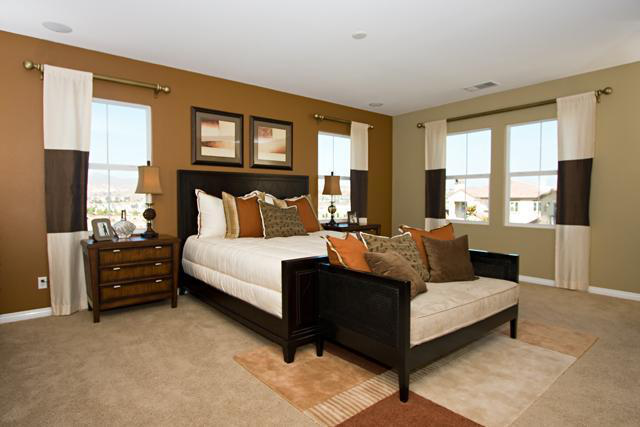

In [20]:
import requests
url="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-seg-image.png"
image=Image.open(requests.get(url, stream=True).raw)
image

In [21]:
image_processor=AutoImageProcessor.from_pretrained("aisuko/"+os.getenv("WANDB_NAME"))

preprocessor_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

In [22]:
encoding=image_processor(image.convert("RGB"), return_tensors="pt")

In [23]:
with torch.no_grad():
    outputs=inference_model(pixel_values=encoding.pixel_values)
    logits=outputs.logits

upsampled_logits=torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg=upsampled_logits.argmax(dim=1)[0]

# Visualize the result

In [24]:
# The original code is here: https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51
# License: Apache License 2.0
# Adapte by Aisuko
# Adapte: Sun 10 Dec 2023
def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

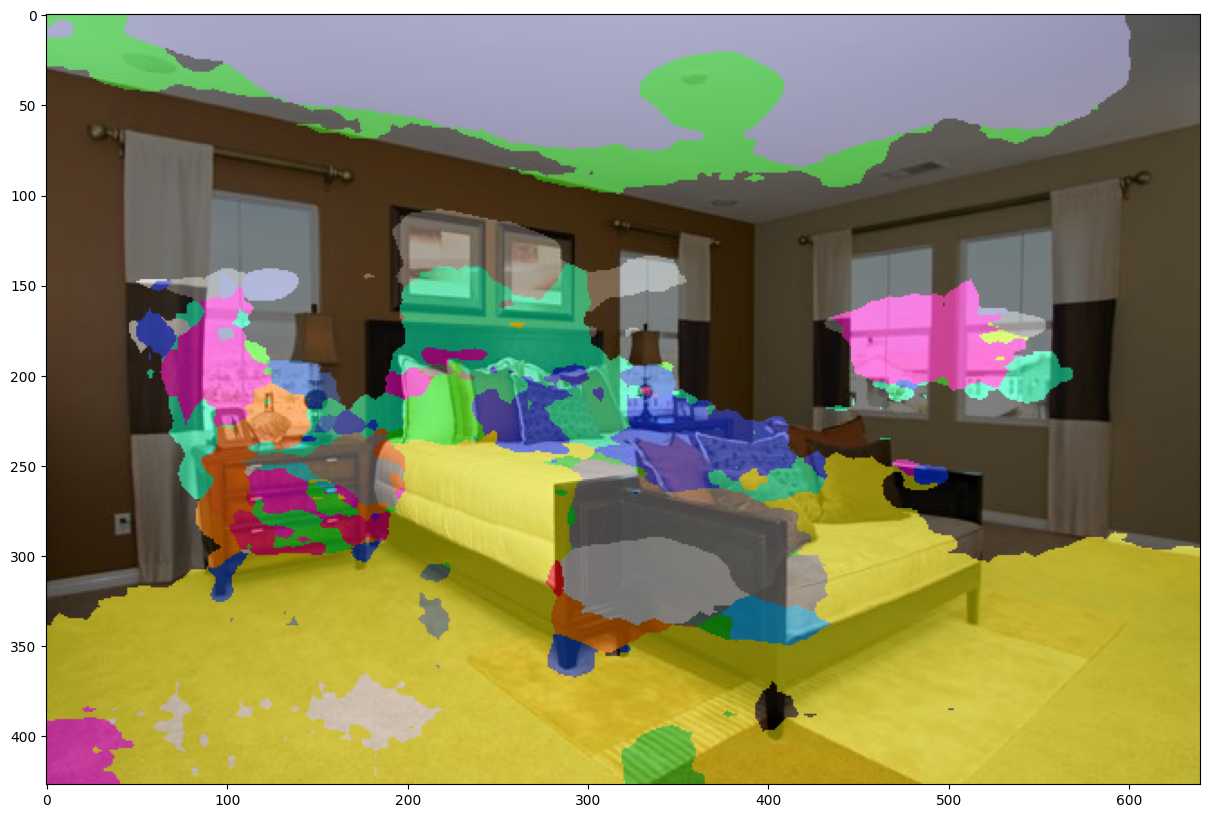

In [25]:
import matplotlib.pyplot as plt

color_seg=np.zeros((pred_seg.shape[0], pred_seg.shape[1],3), dtype=np.uint8)
palette=np.array(create_ade20k_label_colormap())

for label, color in enumerate(palette):
    color_seg[pred_seg==label,:]=color
color_seg=color_seg[...,::-1] # convert to RGB

# plot the image with segmentation map
img=np.array(image)*0.5 +color_seg*0.5
img=img.astype(np.uint8)

plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()